In [1]:
# Necessory Imports 
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import spacy
import nltk
from nltk.corpus import stopwords

import string # Used to remove punctuation
import re

pd.set_option('max_colwidth', 200)
nlp = spacy.load('en_core_web_sm')

In [2]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [3]:
data.count()

Review    20491
Rating    20491
dtype: int64

In [4]:
data.rename(columns={'Review':'review', 'Rating':'rating'}, inplace=True)

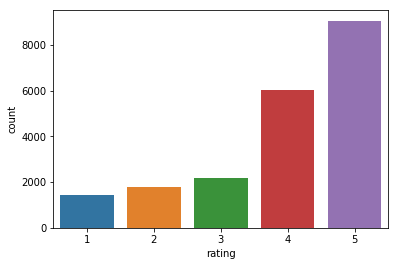

In [5]:
sns.countplot(data=data,x='rating')

In [6]:
data.head()

,review,rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunct...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, probl...",5


In [7]:
# Removing punctuations
print(string.punctuation)
string_punctuation = string.punctuation
def remove_punk(text):
    return text.translate(str.maketrans('','',string_punctuation))
data['review'] = data['review'].apply(lambda t: remove_punk(t))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
# Remove special characters
data['review'] = data['review'].str.lower()

def  remove_special_chars(text):
    text = text.apply(lambda T: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", T))          
    return text

data['review']= remove_special_chars(data['review'])

In [9]:
# Remove stopwords
stop_word = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_word])

data['review'] = data['review'].apply(lambda t: remove_stopwords(t))

In [10]:
# Split data into X and y
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.rating.values)
x_train, x_test, y_train, y_test = train_test_split(data.review.values, y, 
                                                  stratify=y, 
                                                  random_state=25, 
                                                  test_size=0.1, shuffle=True)
xtrain, xvalid, ytrain, yvalid = train_test_split(pd.DataFrame(x_train)[0], y_train, 
                                                  stratify=y_train, 
                                                  random_state=25, 
                                                  test_size=0.1, shuffle=True)

In [11]:
# One hot encoding
ctv = CountVectorizer(stop_words = 'english')
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [12]:
# ctv.get_feature_names()

In [13]:
# Model initialize and fittransform
clf = MultinomialNB(alpha=0.05)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict(xvalid_ctv)

acc_score = metrics.accuracy_score(yvalid, predictions)
f1_score = metrics.f1_score(yvalid, predictions, average='macro')

# print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
# print(classification_report(yvalid,np.argmax(predictions,axis=1)))
# print(acc_score, f1_score)

print('Total accuracy classification score: {}'.format(acc_score))
print('Total F1 classification score: {}'.format(f1_score))
conf_matrix = confusion_matrix(yvalid, predictions)
print('Confusion Matrix:\n {}'.format(conf_matrix))

Total accuracy classification score: 0.5523035230352303
Total F1 classification score: 0.4777614152899643
Confusion Matrix:
 [[ 78  37   6   7   0]
 [ 31  60  47  15   8]
 [ 11  34  53  79  20]
 [  6  31  67 235 205]
 [  7  15  27 173 593]]


In [14]:
from nltk.tokenize import word_tokenize

pos_df = data.head(4).copy()
def get_tokens(text):
    tokenize = word_tokenize(text.lower())
#     print('tokenize:', tokenize)
    return tokenize

pos_df["tokens"] = pos_df['review'].apply(lambda text: get_tokens(text))

In [15]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\siddaram.halli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
def get_postags(tokens):
    postags = nltk.pos_tag(tokens)
    list_classes = list()
    for  word in postags:
        list_classes.append(word[1])
    return list_classes

pos_df["postags"] = pos_df["tokens"].apply(lambda text: get_postags(text))
pos_df.head()

,review,rating,tokens,postags
0,nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappointed nonexistent view room room cl...,4,"[nice, hotel, expensive, parking, got, good, deal, stay, hotel, anniversary, arrived, late, evening, took, advice, previous, reviews, valet, parking, check, quick, easy, little, disappointed, none...","[JJ, NN, JJ, NN, VBD, JJ, NN, VB, NN, JJ, VBD, JJ, NN, VBD, RB, JJ, NNS, NN, VBG, NN, JJ, JJ, JJ, JJ, JJ, NN, NN, NN, JJ, JJ, NN, VBD, JJ, NN, JJ, RB, JJ, NNS, VBP, IN, NN, NN, NN, NN, NN, JJ, NNS..."
1,ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printe...,2,"[ok, nothing, special, charge, diamond, member, hilton, decided, chain, shot, 20th, anniversary, seattle, start, booked, suite, paid, extra, website, description, suite, bedroom, bathroom, standar...","[JJ, NN, JJ, NN, NN, NN, NN, VBD, NN, NN, CD, JJ, JJ, NN, VBD, NN, VBN, JJ, JJ, NN, NN, NN, NN, JJ, NN, NN, VBD, JJ, NN, NN, VBD, VBD, NNS, IN, NN, JJ, NN, NN, NN, VBD, UH, JJ, NNS, VBP, NNP, NN, ..."


In [17]:
# Dependency parser
text = "He is last seen being taken inside Castle Black for treatment while yelling for his men to continue fighting."
for token in nlp(text):
 print(token.text,'=>',token.dep_,'=>',token.head.text)

He => nsubjpass => seen
is => auxpass => seen
last => advmod => seen
seen => ROOT => seen
being => auxpass => taken
taken => xcomp => seen
inside => prep => taken
Castle => compound => Black
Black => pobj => inside
for => prep => taken
treatment => pobj => for
while => mark => yelling
yelling => advcl => taken
for => mark => continue
his => poss => men
men => nsubj => continue
to => aux => continue
continue => advcl => yelling
fighting => xcomp => continue
. => punct => seen
